# Test di Pearson per i dati della stazione di Pian di Fedaia (diga)

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

In [2]:
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

In [3]:
os_DatiFedaia=os.getcwd()
os.chdir(os_DatiFedaia)

In [4]:
data=pd.read_csv('DatiFedaia.csv')
map(datetime,data['Anno'])
data=data.set_index('Anno')
lst=data.columns #['1h','3h','6h','12h','24h']

In [5]:
data

,1h,3h,6h,12h,24h
Anno,,,,,
1919,NaN,NaN,NaN,NaN,NaN
1920,NaN,NaN,NaN,NaN,NaN
1921,NaN,NaN,NaN,NaN,NaN
1922,NaN,NaN,NaN,NaN,NaN
1923,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2006,NaN,NaN,NaN,NaN,NaN
2007,12.6,32.2,43.8,48.6,57.0
2008,40.0,50.8,61.2,83.4,91.8


### Si importano le coppie di parametri ricavate con i precedenti metodi
#### Momenti, Massima Verosimiglianza, Minimi Quadrati

In [6]:
abs_m=pd.read_pickle("abs_m")
abs_mle=pd.read_pickle("abs_mle")
abs_mq=pd.read_pickle("abs_mq")

### Funzione del chi quadro

In [7]:
def X2(data,abs_t,h,delta):
    dt=data[h].dropna()
    
    lh=len(dt)
    
    q=[delta*(i+1) for i in range(int(1/delta))]
    
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    
    o0=lh*r
    
    o=o0-np.append([0],np.delete(o0,-1))
    
    e=[delta*lh for i in range(len(r))]
    
    return ((o-e)**2/e).sum() 

In [8]:
abs_=['abs_m','abs_mq','abs_mle']

### Viene calcolato il chi quadro dei parametri per i vari metodi utilizzati in precedenza

In [9]:
a=[]
for h in data.columns:
    a=a+[[X2(data,abs_m,h,0.2),X2(data,abs_mq,h,0.2),X2(data,abs_mle,h,0.2)]] #0.2 è l'intervallo di probabilità cioè 1/k in questo caso k=5

param=pd.DataFrame(a,index=lst,columns=abs_)
param

,abs_m,abs_mq,abs_mle
1h,6.651163,2.697674,6.418605
3h,4.093023,4.790698,4.093023
6h,12.697674,12.232558,10.604651
12h,3.238095,3.714286,3.714286
24h,7.116279,5.953488,3.395349


### Viene selezionato per ogni intervallo di tempo il metodo che risulta avere il chi quadro minore 

In [10]:
par=param.T

b={}
for i in lst:
    for a in range(1,len(param.columns)-1):
        if par[i][a]<par[i][a+1]:
            best=par.index[a]

        if par[i][a]>par[i][a+1]:
            best=par.index[a+1]

        if par[i][a]>par[i][a-1]:
            best=par.index[a-1]
        b.update({i:best})

In [11]:
b

{'1h': 'abs_mq',
 '3h': 'abs_m',
 '6h': 'abs_mle',
 '12h': 'abs_m',
 '24h': 'abs_mle'}

### Si crea un dataframe con i parametri che per ogni intervallo mi da il chi quadro minore

In [12]:
best=DataFrame([abs_mq["1h"],
                abs_m["3h"],
                abs_mle["6h"],
                abs_m["12h"],
                abs_mle["24h"]]).T
                  
best

,1h,3h,6h,12h,24h
a,12.601354,22.712616,31.960715,48.746973,66.168039
b,3.002031,5.155363,9.341875,13.646262,24.067697


### Salvo i parametri migliori in un file

In [13]:
best.to_pickle("best_param")

### Operazioni preliminari per graficare i risultati

#### Funzione delle curve di Gumbel

In [14]:
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))

#### Spazio lineare

In [15]:
minimo=min(data.min()) #7.2
mass=max(data.max()) #132.6

t_rain=np.linspace(minimo,170,100)

#### Dataframe con i dati per le curve di Gumbel

In [16]:
g=[]
for i in lst:
    g.append(gumbel(t_rain,best,i))
    
gb=pd.DataFrame(g).T
gb.index=t_rain
gb.columns=lst

#### Impostazioni dei grafici

In [17]:
SMALL_SIZE=15
MEDIUM_SIZE=20
BIGGER_SIZE=30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
import random
colors={}
for i in lst:
    colore=(random.random(), random.random(), random.random())
    colors.update({i:colore})

#### Misure dell'ECDF

In [19]:
ecdf={}
for i in lst:
    ecdf.update({i:ECDF(data[i].dropna())})

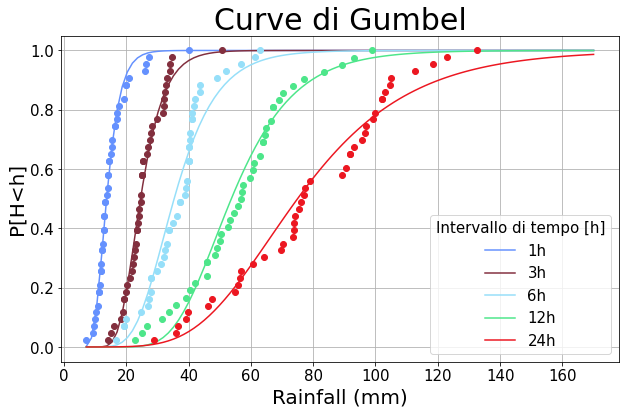

In [20]:
ax=gb.plot(figsize=(10,6),color=[colors['1h'],colors['3h'],colors['6h'],colors['12h'],colors['24h']])
for i in lst:
    ax.plot(data[i].dropna(),ecdf[i](data[i].dropna()),'o',c=colors[i])
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P[H<h]')
ax.grid(True)
ax.legend (title= "Intervallo di tempo [h]")